Calculation of Implied Volatility

In [2]:
"""
name_df เก็บชื่อ stocks ไว้ทั้งหมดที่จะใช้ + ราคา S0, 

เหลือใส่ black scholes เทียยบราคาจาก vol forecast กับ ราคาจริง(จากimplied Vol)
ต้องใช้ S0 (ดึง tvdatafeed ได้)
Strike Price ย้อนสูตร black scholes
"""


'\nname_df เก็บชื่อ stocks ไว้ทั้งหมดที่จะใช้ + ราคา S0, \n\nเหลือใส่ black scholes เทียยบราคาจาก vol forecast กับ ราคาจริง(จากimplied Vol)\nต้องใช้ S0 (ดึง tvdatafeed ได้)\nStrike Price\n'

In [3]:
#in case of dw01

import requests
from bs4 import BeautifulSoup
import pandas as pd
url = 'https://www.blswarrant.com/search'
head = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36'

print('0')

html = requests.get(url, headers={'User-Agent': head}).content
df_list = pd.read_html(html)
df_dw01 = df_list[2]
df_dw01['Stock']='SET:' + df_dw01['DW Symbol'].apply(lambda x: x[:-8])
name_df = pd.DataFrame(df_dw01['Stock'].drop_duplicates())
name_df.reset_index(inplace=True)
name_df = name_df.drop(['index'],axis=1)
name_df

0


,Stock
0,SET:DELTA
1,SET:BH
2,SET:COM7
3,SET:KBANK
4,SET:CBG
...,...
77,SET:TRUE
78,SET:TTB
79,SET:TU
80,SET:VGI


In [4]:
df_dw01 = df_dw01.drop(['Effective Gearing','Sensitivity','Time Decay','Moneyness','Status','Last Trading Date'],axis=1)
df_dw01

,DW Symbol,Imp.Vol.,TTM (days),Stock
0,DELTA01P2408X,88.54%,66,SET:DELTA
1,BH01C2408A,54.17%,66,SET:BH
2,DELTA01C2409A,79.66%,87,SET:DELTA
3,COM701P2408X,72.42%,66,SET:COM7
4,KBANK01C2406A,41.37%,26,SET:KBANK
...,...,...,...,...
293,VGI01P2408X,81.31%,66,SET:VGI
294,WHA01C2405A,97.66%,6,SET:WHA
295,WHA01C2406A,54.58%,26,SET:WHA
296,WHA01C2408A,55.29%,66,SET:WHA


In [5]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

tv = TvDatafeed()
df = tv.get_hist(symbol='SET:SET50', exchange='SET', interval=Interval.in_daily, n_bars=1201)
set50 = df[['close']]
set50.rename(columns = {'close':'remove'}, inplace=True)


you are using nologin method, data you access may be limited
C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_17276\939002430.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set50.rename(columns = {'close':'remove'}, inplace=True)


In [6]:
for i in range (name_df.shape[0]):
    df = tv.get_hist(symbol=name_df['Stock'][i], exchange='SET', interval=Interval.in_daily, n_bars=1201)
    df = df[['close']]
    set50 = pd.merge(set50, df, left_index=True, right_index=True, how='outer')
    set50.rename(columns = {'close':name_df['Stock'][i]}, inplace=True)
set50 = set50.drop('remove',axis=1)

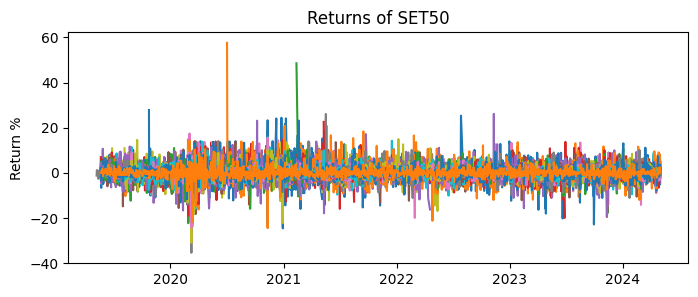

In [7]:
returns = np.log(set50).diff() * 100 #1st difference
plt.figure(figsize=(8,3))
plt.plot(returns)
plt.ylabel("Return %")
plt.title('Returns of SET50');

In [8]:
conclu = name_df[['Stock']]
conclu

,Stock
0,SET:DELTA
1,SET:BH
2,SET:COM7
3,SET:KBANK
4,SET:CBG
...,...
77,SET:TRUE
78,SET:TTB
79,SET:TU
80,SET:VGI


In [9]:
from arch import arch_model
from sklearn.metrics import mean_squared_error
best_model_list = []
for i in range (name_df.shape[0]):

    returns_individual = returns[[name_df['Stock'][i]]]
    returns_individual = returns_individual.dropna()

    real_vol = []
    for i in range(len(returns)):
        vol = returns_individual[:i].std()
        real_vol.append(vol)

    len_test = int(0.2 * len(returns_individual))
    test_vol = real_vol[-len_test:]

    returns_train, returns_test= returns_individual[:-len_test], returns_individual[-len_test:]

    garch_model_fit = arch_model(returns_train,vol="Garch",p=1,q=1).fit(disp='off',update_freq=len(returns_test))
    arch_model_fit = arch_model(returns_train,vol="ARCH").fit(disp='off',update_freq=len(returns_test))
    gjr_garch_model_fit = arch_model(returns_train,p=1,o=1,q=1).fit(disp='off',update_freq=len(returns_test))
    harch_model_fit = arch_model(returns_train,vol='Harch').fit(disp='off',update_freq=len(returns_test))

    garch_forecast = garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    arch_forecast = arch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    gjr_garch_forecast = gjr_garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    harch_forecast = harch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)

    garch = garch_forecast.variance.values[-1,:].flatten()
    arch = arch_forecast.variance.values[-1,:].flatten()
    gjr = gjr_garch_forecast.variance.values[-1,:].flatten()
    harch = harch_forecast.variance.values[-1,:].flatten()

    df_test = returns_test.copy()
    df_test['garch']= np.sqrt(garch)
    df_test['arch']= np.sqrt(arch)
    df_test['gjr']= np.sqrt(gjr)
    df_test['harch']= np.sqrt(harch)
    df_test['Vol'] = np.array(test_vol)

    garch_mae = mean_squared_error(df_test['Vol'],df_test['garch'])
    arch_mae = mean_squared_error(df_test['Vol'],df_test['arch'])
    gjr_garch_mae = mean_squared_error(df_test['Vol'],df_test['gjr'])
    harch_mae = mean_squared_error(df_test['Vol'],df_test['harch'])
    mae = [garch_mae,arch_mae,gjr_garch_mae,harch_mae]
    best = mae.index(min(mae))

    if best == 0:
        mod = 'garch'
    elif best == 1:
        mod = 'arch'
    elif best == 2:
        mod = 'gjr'
    elif best == 3:
        mod = 'harch'
    best_model_list.append(mod)

conclu['Suggested Models'] = np.array(best_model_list)

In [10]:
volatility_list_g = []
volatility_list_a = []
volatility_list_gj = []
volatility_list_h = []
for i in range (len(df_dw01)):
    returns_individual = returns[[df_dw01['Stock'][i]]].dropna()
    forecast_model_fit_g = arch_model(returns_individual,vol="Garch", p=1,q=1).fit(disp='off')
    forecast_model_fit_a = arch_model(returns_individual,vol="ARCH").fit(disp='off')
    forecast_model_fit_gj = arch_model(returns_individual,p=1,o=1,q=1).fit(disp='off')
    forecast_model_fit_h = arch_model(returns_individual,vol="Harch").fit(disp='off')
    forecast_g = forecast_model_fit_g.forecast(horizon=df_dw01['TTM (days)'][i],method='analytic',reindex=True)
    forecast_a = forecast_model_fit_a.forecast(horizon=df_dw01['TTM (days)'][i],method='analytic',reindex=True)
    forecast_gj = forecast_model_fit_gj.forecast(horizon=df_dw01['TTM (days)'][i],method='analytic',reindex=True)
    forecast_h = forecast_model_fit_h.forecast(horizon=df_dw01['TTM (days)'][i],method='analytic',reindex=True)
    
    y = forecast_g.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(252)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_g.append(vol6m)

    y = forecast_a.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(252)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_a.append(vol6m)

    y = forecast_gj.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(252)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_gj.append(vol6m)

    y = forecast_h.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(252)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_h.append(vol6m)
    
df_dw01['Vol_Garch'] = np.array(volatility_list_g)
df_dw01['Vol_Arch'] = np.array(volatility_list_a)
df_dw01['Vol_GJR'] = np.array(volatility_list_gj)
df_dw01['Vol_Harch'] = np.array(volatility_list_h)

C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_17276\1022429969.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol6m = float(df_y['forecast'].tail(1))
C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_17276\1022429969.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol6m = float(df_y['forecast'].tail(1))
C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_17276\1022429969.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol6m = float(df_y['forecast'].tail(1))
C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_17276\1022429969.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol6m = float(df_y['

In [11]:
summary = pd.merge(df_dw01,conclu,on='Stock')
result = []
for i in range(len(summary)):
    if summary['Suggested Models'][i] == 'garch':
        result.append(summary['Vol_Garch'][i])
    elif summary['Suggested Models'][i] == 'arch':
        result.append(summary['Vol_Arch'][i])
    elif summary['Suggested Models'][i] == 'gjr':
        result.append(summary['Vol_GJR'][i])
    elif summary['Suggested Models'][i] == 'harch':
        result.append(summary['Vol_Harch'][i])

summary['Suggested Model Results'] = np.array(result)
summary['Imp.Vol.'] = summary['Imp.Vol.'].apply(lambda x:x[:-1]).astype(float)

summary['Imp.Vol. - Forecasted Vol.'] = summary['Imp.Vol.'] - summary['Suggested Model Results']
summary


,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.
0,DELTA01P2408X,88.54,66,SET:DELTA,69.827879,71.418408,67.633856,71.417787,garch,69.827879,18.712121
1,BH01C2408A,54.17,66,SET:BH,31.141840,30.245003,31.136899,30.245068,arch,30.245003,23.924997
2,DELTA01C2409A,79.66,87,SET:DELTA,69.828842,71.418408,67.668092,71.417787,garch,69.828842,9.831158
3,COM701P2408X,72.42,66,SET:COM7,39.189235,39.883975,41.687203,39.884371,arch,39.883975,32.536025
4,KBANK01C2406A,41.37,26,SET:KBANK,21.244772,34.972524,18.158935,34.972633,arch,34.972524,6.397476
...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2408X,81.31,66,SET:VGI,44.878061,41.278337,43.735617,41.278363,arch,41.278337,40.031663
294,WHA01C2405A,97.66,6,SET:WHA,24.209078,34.460115,23.199227,34.460159,arch,34.460115,63.199885
295,WHA01C2406A,54.58,26,SET:WHA,26.326062,34.478406,25.379494,34.478452,arch,34.478406,20.101594
296,WHA01C2408A,55.29,66,SET:WHA,29.056648,34.478406,28.122587,34.478452,arch,34.478406,20.811594


In [12]:
#summary.to_excel('Summary.xlsx')

In [13]:
#  ต้องเข้าลิงค์แต่ละอันไปเอา strike pricehttps://www.blswarrant.com/mydw/DELTA01P2408X
# หาw,jw
for i in range(len(summary)):
    pass

In [18]:
url = 'https://www.blswarrant.com/mydw/DELTA01P2408X'
head = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36'

print('0')

html = requests.get(url, headers={'User-Agent': head}).content
df_list = pd.read_html(html)

0


ValueError: invalid literal for int() with base 10: '100%'

In [ ]:
#Black Scholes
